(serving-ml-dl-models)=
# Serving pre-trained ML/DL models

This notebook demonstrate how to serve standard ML/DL models using **MLRun Serving**.

Make sure you went over the basics in MLRun [**Quick Start Tutorial**](https://docs.mlrun.org/en/latest/tutorial/01-mlrun-basics.html).


MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files.
The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere.
[Nuclio](https://nuclio.io/) is a high-performance open-source "serverless" framework that's focused on data, I/O, and compute-intensive workloads.


MLRun serving supports advanced real-time data processing and model serving pipelines.<br>
For more details and examples, see the [MLRun serving pipelines](https://docs.mlrun.org/en/latest/serving/serving-graph.html) documentation.

Tutorial steps:
- [**Using pre-built MLRun serving classes and images**](#pre-built-serving)
- [**Create and test the serving function**](#create-function)
- [**Deploy the serving function**](#deploy-serving)
- [**Build a custom serving class**](#custom-class)
- [**Building advanced model serving graph**](#serving=graph)

<iframe width="560" height="315" src="https://www.youtube.com/embed/OUjOus4dZfw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

## MLRun installation and configuration

Before running this notebook make sure the `mlrun` package is installed (`pip install mlrun`) and that you have configured the access to MLRun service. 

In [ ]:
# Install MLRun if not installed, run this only once. Restart the notebook after the install!
%pip install mlrun

**Get or create a new project**

You should create, load or use (get) an [MLRun Project](https://docs.mlrun.org/en/latest/projects/project.html). The `get_or_create_project()` method tries to load the project from the MLRun DB. If the project does not exist, it creates a new one.

In [1]:
import mlrun

project = mlrun.get_or_create_project("tutorial", context="./", user_project=True)

> 2024-08-06 09:21:08,324 [info] Project loaded successfully: {"project_name":"tutorial"}


<a id="pre-built-serving"></a>
## Using pre-built MLRun serving classes

MLRun contains built-in serving functionality for the major ML/DL frameworks (Scikit-Learn, TensorFlow.Keras, ONNX, XGBoost, LightGBM, and PyTorch). 

The following table specifies, for each framework, the corresponding MLRun `ModelServer` serving class and its dependencies:

|framework       |serving class                               |dependencies
|:---------------|:-------------------------------------------|:-------------|
|SciKit-Learn    |mlrun.frameworks.sklearn.SklearnModelServer |scikit-learn  |
|TensorFlow.Keras|mlrun.frameworks.tf_keras.TFKerasModelServer|tensorflow  |
|ONNX            |mlrun.frameworks.onnx.ONNXModelServer       |onnxruntime   |
|XGBoost         |mlrun.frameworks.xgboost.XGBoostModelServer |xgboost  |
|LightGBM        |mlrun.frameworks.lgbm.LGBMModelServer       |lightgbm  |
|PyTorch         |mlrun.frameworks.pytorch.PyTorchModelServer |torch  |

> For GPU support use the `mlrun/mlrun-gpu` image (adding GPU drivers and support).

**Example using SKlearn and TF Keras models**

See how to specify the parameters in the following two examples. These use standard pre-trained models (using the iris dataset) stored in MLRun samples repository. (You can use your own models instead.)

In [2]:
models_dir = mlrun.get_sample_path("models/serving/")

# We choose the correct model to avoid pickle warnings
import sys

suffix = (
    mlrun.__version__.split("-")[0].replace(".", "_")
    if sys.version_info[1] > 7
    else "3.7"
)

framework = "sklearn"  # change to 'keras' to try the 2nd option
kwargs = {}
if framework == "sklearn":
    serving_class = "mlrun.frameworks.sklearn.SklearnModelServer"
    model_path = models_dir + f"sklearn-{suffix}.pkl"
    image = "mlrun/mlrun"
    requirements = []
else:
    serving_class = "mlrun.frameworks.tf_keras.TFKerasModelServer"
    model_path = models_dir + "keras.h5"
    image = "mlrun/mlrun"  # or mlrun/mlrun-gpu when using GPUs
    kwargs["labels"] = {"model-format": "h5"}
    requirements = ["tensorflow==2.8.1"]
    %pip install tensorflow==2.8.1

### Log the model

The model and its metadata are first registered in MLRun's **Model Registry**. Use the `log_model()` method to specify the model files and metadata (metrics, schema, parameters, etc.).

In [3]:
import pandas as pd

model_object = project.log_model(
    f"{framework}-model",
    model_file=model_path,
    training_set=pd.DataFrame(
        data=[[1.5, 1.5, 1.5, 1.5]],
        columns=[
            "sepal_length_cm",
            "sepal_width_cm",
            "petal_length_cm",
            "petal_width_cm",
        ],
    ),
    **kwargs,
)

<a id="create-function"></a>
## Create and test the serving function 

Create a new **`serving`** function, specify its `name` and the correct `image` (with your desired framework).

> If you want to add specific packages to the base image, specify the `requirements` attribute, example:
> 
> ```python
> serving_fn = project.set_function(name="serving", image=image, kind="serving", requirements=["tensorflow==2.8.1"])
> ```

The following example uses a basic topology of a model `router` and adds a single model behind it. (You can add multiple models to the same function.)

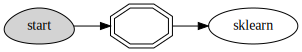

In [4]:
import pandas as pd

serving_fn = project.set_function(
    name="serving", image=image, kind="serving", requirements=requirements
)
serving_fn.add_model(
    framework, model_path=model_object.uri, class_name=serving_class, to_list=True
)

# Plot the serving topology input -> router -> model
serving_fn.plot(rankdir="LR")

**Simulate the model server locally (using the mock_server)**

In [5]:
# Create a mock server that represents the serving pipeline
server = serving_fn.to_mock_server()

> 2024-08-06 09:21:08,641 [warning] run command, file or code were not specified
> 2024-08-06 09:21:14,893 [info] model sklearn was loaded
> 2024-08-06 09:21:14,894 [info] Loaded ['sklearn']


<br>

**Test the mock model server endpoint**
    
- List the served models

In [6]:
server.test("/v2/models/", method="GET")

{'models': ['sklearn']}

- Infer using test data

In [7]:
sample = {"inputs": [[5.2, 2.7, 3.9, 1.4], [6.4, 3.1, 5.5, 1.8]]}
server.test(path=f"/v2/models/{framework}/infer", body=sample)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


{'id': 'e75c42b1daf9494d9900e7fdef193f0e',
 'model_name': 'sklearn',
 'outputs': [1, 2]}

See more API options and parameters in [Model serving API](https://docs.mlrun.org/en/latest/serving/model-api.html).

<a id="deploy-serving"></a>
## Deploy the serving function

Deploy the serving function and use `invoke` to test it with the provided `sample` by using 2 API's `infer` & `infer_dict`.

In [8]:
project.deploy_function(serving_fn)

> 2024-08-06 09:21:15,039 [info] Starting remote function deploy
2024-08-06 09:21:15  (info) Deploying function
2024-08-06 09:21:15  (info) Building
2024-08-06 09:21:15  (info) Staging files and preparing base images
2024-08-06 09:21:15  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-08-06 09:21:15  (info) Building processor image
2024-08-06 09:23:30  (info) Build complete
2024-08-06 09:23:40  (info) Function deploy complete
> 2024-08-06 09:23:46,810 [info] Successfully deployed function: {"external_invocation_urls":["tutorial-admin-serving.default-tenant.app.dev13.lab.iguazeng.com/"],"internal_invocation_urls":["nuclio-tutorial-admin-serving.default-tenant.svc.cluster.local:8080"]}


DeployStatus(state=ready, outputs={'endpoint': 'http://tutorial-admin-serving.default-tenant.app.dev13.lab.iguazeng.com/', 'name': 'tutorial-admin-serving'})

In [9]:
serving_fn.invoke(path=f"/v2/models/{framework}/infer", body=sample)

> 2024-08-06 09:23:46,895 [info] Invoking function: {"method":"POST","path":"http://nuclio-tutorial-admin-serving.default-tenant.svc.cluster.local:8080/v2/models/sklearn/infer"}


{'id': 'e26ca488-cd0a-4898-af27-17d19cf0b5ab',
 'model_name': 'sklearn',
 'outputs': [1, 2],
 'model_version': 'latest'}

In [10]:
sample_dict = {
    "inputs": [
        {
            "sepal_length_cm": 5.2,
            "sepal_width_cm": 2.7,
            "petal_length_cm": 3.9,
            "petal_width_cm": 1.4,
        },
        {
            "sepal_length_cm": 6.4,
            "sepal_width_cm": 3.1,
            "petal_width_cm": 1.8,
            "petal_length_cm": 5.5,
        },
    ]
}

serving_fn.invoke(path=f"/v2/models/{framework}/infer_dict", body=sample_dict)

> 2024-08-06 09:23:47,202 [info] Invoking function: {"method":"POST","path":"http://nuclio-tutorial-admin-serving.default-tenant.svc.cluster.local:8080/v2/models/sklearn/infer_dict"}


{'id': '1911b48b-2cc4-4bcb-8270-4d6e98247c2b',
 'model_name': 'sklearn',
 'outputs': [1, 2],
 'model_version': 'latest'}

<a id="custom-class"></a>
## Build a custom serving class

Model serving classes implement the full model serving functionality, which include loading models, pre- and post-processing, prediction, explainability, and model monitoring.

Model serving classes must inherit from `mlrun.serving.V2ModelServer`, and at the minimum implement the `load()` (download the model file(s) and load the model into memory) and `predict()` (accept request payload and return prediction/inference results) methods.

For more detailed information on custom serving classes, see [Build your own model serving class](https://docs.mlrun.org/en/latest/serving/custom-model-serving-class.html).

The following code demonstrates a minimal scikit-learn (a.k.a. sklearn) serving-class implementation:


```python
from cloudpickle import load
import numpy as np
from typing import List
import mlrun

class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self) -> None:
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))

    def predict(self, body: dict) -> list:
        """Generate model predictions from sample."""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()
```

In order to create a function that incorporates the code of the new class (in `serving.py` ) use `code_to_function`:

```python
serving_fn = mlrun.code_to_function('serving', filename='serving.py', kind='serving',image='mlrun/mlrun')
serving_fn.add_model('my_model',model_path=model_file, class_name='ClassifierModel')
```

<a id="serving=graph"></a>
## Build an advanced model serving graph

MLRun graphs enable building and running DAGs (directed acyclic graphs). Graphs are composed of individual steps. 
The first graph element accepts an `Event` object, transforms/processes the event and passes the result to the next step
in the graph, and so on. The final result can be written out to a destination (file, DB, stream, etc.) or returned back to the caller 
(one of the graph steps can be marked with `.respond()`). 

The serving graphs can be composed of [pre-defined graph steps](../serving/available-steps.html), block-type elements (model servers, routers, ensembles, 
data readers and writers, data engineering tasks, validators, etc.), [custom steps](..serving/writing-custom-steps.html), or from native python 
classes/functions. A graph can have data processing steps, model ensembles, model servers, post-processing, etc. 
Graphs can auto-scale and span multiple function containers (connected through streaming protocols).

See the [Advanced Model Serving Graph Notebook Example](../serving/graph-example.htm).

## Done!

Congratulations! You've completed Part 3 of the MLRun getting-started tutorial.
Proceed to [**Part 4: ML Pipeline**](04-pipeline.html) to learn how to create an automated pipeline for your project.